In [700]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import cdist

In [289]:
cases_text_onlyspeaker_df = pd.read_csv("cases_text_onlyspeaker.csv")
cases_text_onlyspeaker_df.head()

,new_name,sentence,sentence_clean,topic_mentioned,sentiment,prob_score_neg,prob_score_neutral,prob_score_pos,has_parking,has_econactivity,...,sent_voice_mentioned,sentpol_voice_mentioned,prob_pos_voice_mentioned,prob_neg_voice_mentioned,positive_voice_mentioned,negative_voice_mentioned,num_voice_mentioned,num_sentences,sentence_lower,count_my_name
0,09-12-2017audio_6ZA-2017-210-CU-1A,My name is Jerry Newman.,My name is Jerry Newman.,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,my name is jerry newman.,1
1,09-12-2017audio_6ZA-2017-210-CU-1A,"Thank you, President Chunkham, members of the ...","Thank you, President Chunkham, members of the ...",NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,"thank you, president chunkham, members of the ...",0
2,09-12-2017audio_6ZA-2017-210-CU-1A,The question that is asked and that was asked ...,The question that is asked and that was asked ...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,the question that is asked and that was asked ...,0
3,09-12-2017audio_6ZA-2017-210-CU-1A,And I think Mr. Chang made an adequate descrip...,And I think Mr. Chang made an adequate descrip...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,and i think mr. chang made an adequate descrip...,0
4,09-12-2017audio_6ZA-2017-210-CU-1A,We started thinking through a business plan an...,We started thinking through a business plan an...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,we started thinking through a business plan an...,0


Load Sentence Embedding Model

In [290]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Get Embeddings

In [291]:
def get_embeddings(column):
  parking_rows = cases_text_onlyspeaker_df[cases_text_onlyspeaker_df[column] == 1]
  all_sentences = parking_rows["sentence"].tolist()
  
  return model.encode(all_sentences), all_sentences

Get Optimal k Clusters (Elbow Test)

In [292]:
def elbow_test(embeddings):
  inertias = []
  k_values = range(1, 20)

  for k in k_values:
      clustering_model = KMeans(n_clusters=k, random_state=0)
      clustering_model.fit(embeddings)
      inertias.append(clustering_model.inertia_)

  plt.figure(figsize=(8, 4))
  plt.plot(k_values, inertias, 'bo-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia (Sum of Squared Distances)')
  plt.title('Elbow Test for Optimal k')
  plt.grid(True)
  plt.show()

K-means Classifier

In [547]:
def get_labeled_sentences(label_file):
  labeled_sentences_df = pd.read_csv(label_file)
  labeled_sentences_ls = labeled_sentences_df["sentence"].tolist()
  labeled_sentences_embedded = model.encode(labeled_sentences_ls)

  return labeled_sentences_embedded

In [576]:
# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
#   clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#   clustering_model.fit(embeddings)
#   clusters = clustering_model.labels_

#   return clusters, clustering_model

#voting
# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10, test_embeddings=None):
#     n_samples = embeddings.shape[0]
#     all_clusters = np.zeros((n_init, n_samples), dtype=int)
#     all_models = []

#     # Run K-means multiple times and collect the cluster labels
#     for i in range(n_init):
#         clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i*100)
#         clustering_model.fit(embeddings)
#         all_clusters[i] = clustering_model.labels_
#         all_models.append(clustering_model)

#     # Perform voting (finding the most common cluster assignment for each observation)
#     final_clusters = mode(all_clusters, axis=0)[0].flatten()

#     # Fit the final model with the final clusters
#     final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#     final_clustering_model.fit(embeddings)
    
#     if test_embeddings is not None:
#         # Predict clusters for test set using voting
#         test_predictions = np.zeros((n_init, test_embeddings.shape[0]), dtype=int)
#         for i, model in enumerate(all_models):
#             test_predictions[i] = model.predict(test_embeddings)
        
#         final_test_predictions = mode(test_predictions, axis=0)[0].flatten()
#         return final_clusters, final_test_predictions
    
#     return final_clusters



# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
#     n_samples = embeddings.shape[0]
#     consensus_matrix = np.zeros((n_samples, n_samples))

#     # Run K-means with random initializations and update the consensus matrix
#     for i in range(n_init):
#         # K-Means with a different random seed each time for diverse initialization
#         clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i)
#         clustering_model.fit(embeddings)
#         clusters = clustering_model.labels_
        
#         # Update the consensus matrix
#         for j in range(n_samples):
#             for k in range(j + 1, n_samples):
#                 if clusters[j] == clusters[k]:
#                     consensus_matrix[j, k] += 1
#                     consensus_matrix[k, j] += 1

#     # Normalizing the consensus matrix
#     consensus_matrix /= n_init
    
#     # Final clustering using the consensus matrix
#     final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#     weighted_embeddings = np.dot(consensus_matrix, embeddings)
#     final_clustering_model.fit(weighted_embeddings)
#     final_clusters = final_clustering_model.labels_

#     return final_clusters, final_clustering_model


In [701]:
def match_clusters(centroids, reference_centroids):
    """
    Match clusters from different K-means runs to ensure consistent labeling.
    
    Args:
    centroids (np.array): Centroids from the current K-means run.
    reference_centroids (np.array): Centroids from the reference K-means run.
    
    Returns:
    list: Matched indices for each centroid.
    """
    matches = []
    for centroid in centroids:
        distances = cdist([centroid], reference_centroids, 'euclidean')
        match = np.argmin(distances)
        matches.append(match)
    return matches

def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10, test_embeddings=None):
    """
    Perform K-means clustering with multiple initializations and consensus voting.
    
    Args:
    embeddings (np.array): Input data for clustering.
    num_clusters (int): Number of clusters to form.
    seed (int): Random seed for reproducibility.
    n_init (int): Number of times to run K-means with different initializations.
    test_embeddings (np.array, optional): Test data for prediction.
    
    Returns:
    np.array: Final cluster assignments for input data.
    np.array (optional): Cluster predictions for test data, if provided.
    """
    n_samples = embeddings.shape[0]
    all_clusters = np.zeros((n_init, n_samples), dtype=int)
    all_models = []
    all_centroids = []

    #run K-means multiple times with different initializations
    for i in range(n_init):
        clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i*100)
        clustering_model.fit(embeddings)
        all_clusters[i] = clustering_model.labels_
        all_models.append(clustering_model)
        all_centroids.append(clustering_model.cluster_centers_)

    #use the centroids from the first run as the reference
    reference_centroids = all_centroids[0]

    #align cluster labels across different runs
    aligned_clusters = np.zeros_like(all_clusters)
    aligned_clusters[0] = all_clusters[0]

    for i in range(1, n_init):
        matches = match_clusters(all_centroids[i], reference_centroids)
        aligned_clusters[i] = np.array([matches[label] for label in all_clusters[i]])

    #perform consensus voting to determine final cluster assignments
    final_clusters = mode(aligned_clusters, axis=0)[0].flatten()

    #fit a final model using the consensus cluster assignments
    final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
    final_clustering_model.fit(embeddings)

    if test_embeddings is not None:
        #predict clusters for test set using the aligned models
        test_predictions = np.zeros((n_init, test_embeddings.shape[0]), dtype=int)
        for i, model in enumerate(all_models):
            test_predictions[i] = model.predict(test_embeddings)
        
        # align test set predictions according to the reference model
        aligned_test_predictions = np.zeros_like(test_predictions)
        aligned_test_predictions[0] = test_predictions[0]

        for i in range(1, n_init):
            matches = match_clusters(all_centroids[i], reference_centroids)
            aligned_test_predictions[i] = np.array([matches[label] for label in test_predictions[i]])

        #perform consensus voting on the aligned test predictions
        final_test_predictions = mode(aligned_test_predictions, axis=0)[0].flatten()
        return final_clusters, final_test_predictions
    
    return final_clusters

Visualize Clusters

In [294]:
def pca_plot(embeddings, clusters):
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(embeddings)

  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='rainbow', alpha=0.7)
  ax.view_init(elev=30, azim=120)


  ax.set_title('3D PCA of Sentence Embeddings with K-Means Clustering')
  ax.set_xlabel('PCA Component 1')
  ax.set_ylabel('PCA Component 2')
  ax.set_zlabel('PCA Component 3')

  plt.colorbar(scatter, ax=ax, label='Cluster ID')
  plt.show()

In [295]:
def example_sentences(clustered_sentences, num_clusters, samples):
  for i in range(num_clusters):
      print(f"\nCluster {i}:")
      example_sentences = clustered_sentences[clustered_sentences['Cluster'] == i]['Sentence'].sample(samples)
      for sentence in example_sentences:
          print(f"- {sentence}")

In [296]:
def display_cluster_breakdown(clusters_df, cluster_labels):
  cluster_counts = clusters_df['Cluster'].value_counts().sort_index()
  total_sentences = cluster_counts.sum()

  cluster_data = []
  for cluster_num, count in cluster_counts.items():
      percentage = (count / total_sentences) * 100
      label = cluster_labels[cluster_num]
      cluster_data.append({
          'Cluster': cluster_num,
          'Pct of Sentences': f"{percentage:.2f}%",
          'Manual Guessed Label': label
      })

  cluster_breakdown_df = pd.DataFrame(cluster_data)
  cluster_breakdown_df.set_index('Cluster', inplace=True)

  return cluster_breakdown_df

Topic: Parking

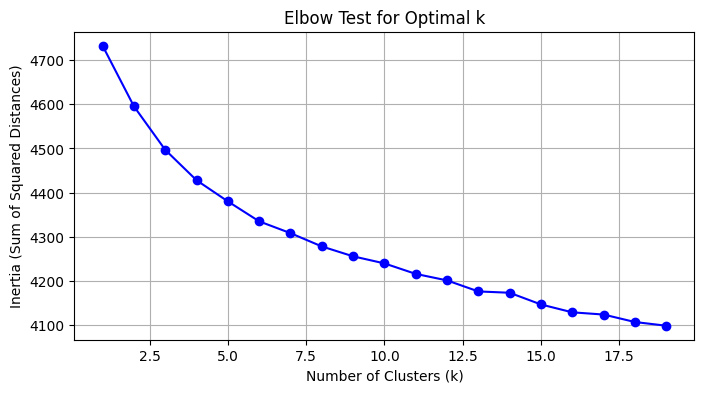

In [297]:
parking_embeddings, parking_sentences = get_embeddings('has_parking')
elbow_test(parking_embeddings)

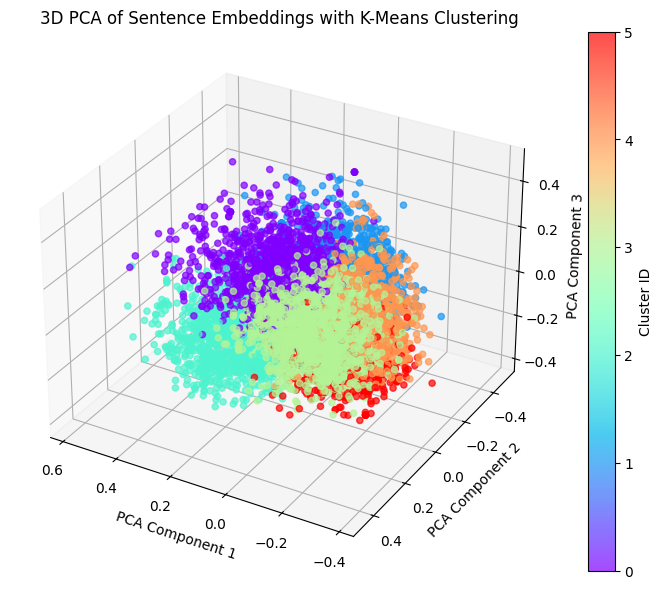

In [695]:
parking_num_clusters = 6

test_parking_sentences_embedded = get_labeled_sentences("labels/parking_labeled.csv")
parking_clusters, parking_pred = k_means_classifier(parking_embeddings, num_clusters=parking_num_clusters, seed=32, n_init=30, test_embeddings=test_parking_sentences_embedded)

parking_clusters_df = pd.DataFrame({'Sentence': parking_sentences, 'Cluster': parking_clusters})
pca_plot(parking_embeddings, parking_clusters)

In [702]:
parking_pred_ls = parking_pred.tolist()
print("lack parking")
print(parking_pred_ls[0:10])
print("parking relative to proposed project")
print(parking_pred_ls[10:15])
print(parking_pred_ls[15:19])
print("zoning, planning, beauracracy")
print(parking_pred_ls[19:27])
print(parking_pred_ls[25:])

lack parking
[4, 4, 4, 5, 3, 5, 5, 1, 5, 5]
parking relative to proposed project
[3, 0, 0, 0, 0]
[0, 1, 4, 4]
zoning, planning, beauracracy
[0, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 2, 0]


In [703]:
parking_example_sentences = 4
example_sentences(parking_clusters_df, parking_num_clusters, parking_example_sentences)


Cluster 0:
- The applicant is proposing to maintain the same number of schooling Romans, same number of structure, same number of overall square footage, and also the outside parking withoutany physical expansion.
- And then otherwise Im just supportive of having some housing in this area and developing the surface parking lot.
- It was not only in meeting with the neighborhood council and the community concerns that this came up, but alsowith the citys design team to talk about treatment of the parking structure.
- So we can only hope that the handshake deal holds and theres not another developer that comes in and doesnt read any of this stuff and just goes with 45 foot 14 units and no parkingwhich would be a nightmare.

Cluster 1:
- And to have a monitor parking attendant as as articulated by the zoning administrator from Friday at five through Sunday closing.
- For the same token, I dont know that anybody is allowed to use from one generation parking lot.
- And so just looking at t

In [704]:
parking_cluster_labels = {
    0: "parking relative to proposed project",
    1: "zoning, planning, beauracracy",
    2: " ",
    3: "",
    4: "",
    5: "lack of parking"
}



parking_cluster_breakdown_df = display_cluster_breakdown(parking_clusters_df, parking_cluster_labels)
parking_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,15.65%,parking relative to proposed project
1,18.11%,"zoning, planning, beauracracy"
2,14.42%,
3,20.60%,
4,19.46%,
5,11.75%,lack of parking


Topic: Nuisance

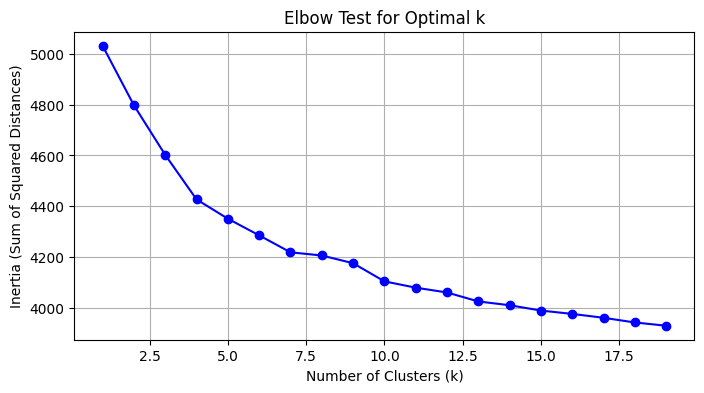

In [705]:
nuisance_embeddings, nuisance_sentences = get_embeddings('has_nuisance')
elbow_test(nuisance_embeddings)

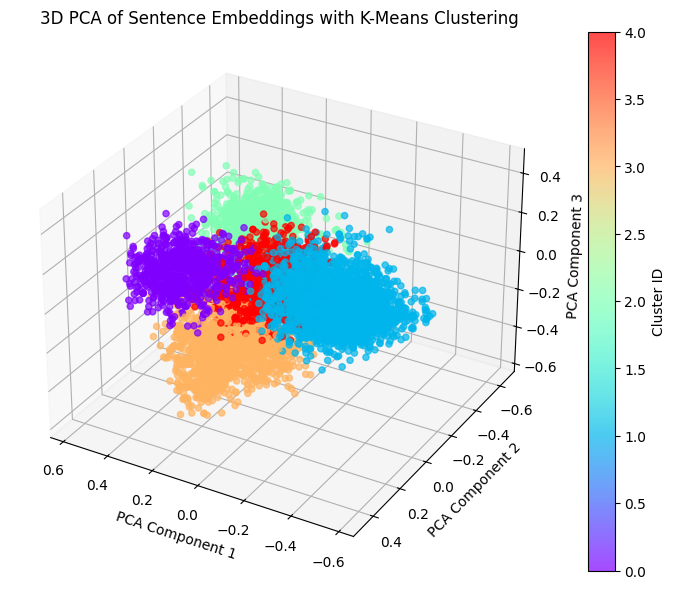

In [707]:
nuisance_num_clusters = 5

test_nuisance_sentences_embedded = get_labeled_sentences("labels/nuisance_labeled.csv")
nuisance_clusters, nuisance_pred = k_means_classifier(nuisance_embeddings, num_clusters=nuisance_num_clusters, seed=42, n_init=30, test_embeddings=test_nuisance_sentences_embedded)

nuisance_clusters_df = pd.DataFrame({'Sentence': nuisance_sentences, 'Cluster': nuisance_clusters})
pca_plot(nuisance_embeddings, nuisance_clusters)

In [708]:
nuisance_example_sentences = 4
example_sentences(nuisance_clusters_df, nuisance_num_clusters, nuisance_example_sentences)


Cluster 0:
- For example, if all of the habitable rooms were greater than four habitable open spaces, I mean, if the Each dwelling unit was greater than four-habit open spaces.
- This is to remain public open space, landscaped as part of the Vista going to Venice Beachis the ceremonial gateway.
- The way the building is proposed, there will be no open space.
- Theres also substantial open space.

Cluster 1:
- Brownwood School has worked diligently as youve heard today to find adequate measurements and controls that satisfy the needs of its most impacted neighbors on the vice of very qualified traffic engineers.
- And as weve discussed, the project must reduce traffic by stepping down trips first through an initial reduction and then through subsequent reduction prior to an at full enrollment.
- Theres right hand arrows and the traffic that comes through you sometimes youre sitting there at three green signals before you can actually cross this intersection.
- This has been deemed acce

In [709]:
nuisance_cluster_labels = {
    0: "importance and management of open spaces",
    1: "traffic, local infrastructure",
    2: "noise, privacy",
    3: "security, crime",
    4: " "
}


nuisance_cluster_breakdown_df = display_cluster_breakdown(nuisance_clusters_df, nuisance_cluster_labels)
nuisance_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,12.13%,importance and management of open spaces
1,39.33%,"traffic, local infrastructure"
2,17.56%,"noise, privacy"
3,18.84%,"security, crime"
4,12.14%,


Topic: Affordable Housing

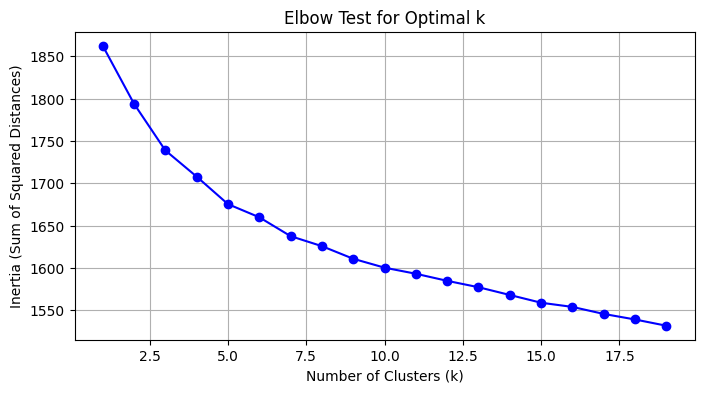

In [710]:
affordable_housing_embeddings, affordable_housing_sentences = get_embeddings('has_affordablehousing')
elbow_test(affordable_housing_embeddings)

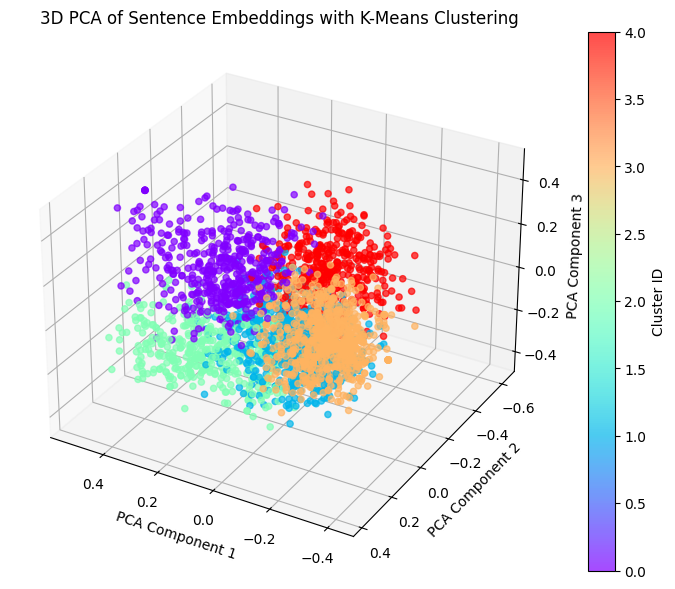

In [735]:
affordable_housing_num_clusters = 5

test_affordable_housing_sentences_embedded = get_labeled_sentences("labels/affordablehousing_labeled.csv")
affordable_housing_clusters, affordable_housing_pred = k_means_classifier(affordable_housing_embeddings, num_clusters=affordable_housing_num_clusters, seed=42, n_init=30, test_embeddings=test_affordable_housing_sentences_embedded)

affordable_housing_clusters_df = pd.DataFrame({'Sentence': affordable_housing_sentences, 'Cluster': affordable_housing_clusters})
pca_plot(affordable_housing_embeddings, affordable_housing_clusters)

In [738]:
affordable_housing_example_sentences = 4
example_sentences(affordable_housing_clusters_df, affordable_housing_num_clusters, affordable_housing_example_sentences)


Cluster 0:
- The point that Im making is that the chart itself compared to what youre telling me, I think its relatively fair in terms of the valuation, but and also this is the only thing that we have to go off of to tie in an affordable covenant.
- Also I dont think you should approve anything like this until we have more affordable programs.
- You cant, they cant afford Napa, Palomino, all these other ones.
- So we provide consultation for senior to in low-income medical children to in low-income health family.

Cluster 1:
- I understandthat its an affordable project and that theres a fixed budget but with it being government-owned land.
- Id like to just briefly state that we believe the project is appropriate for the site that its compatible with the mix of uses that are in the area and that importantly for us it includes necessary and and very valuable affordable housing units.
- So I cant say that the incentives dont result in actual cost reductions because what the, incentives

In [743]:
affordable_housing_cluster_labels = {
    0: "challenges of providing affordable housing, cost, affordability",
    1: "",
    2: "debates on exact number of affordable units, economic feasibility",
    3: "",
    4: "renting"
}


affordable_housing_cluster_breakdown_df = display_cluster_breakdown(affordable_housing_clusters_df, affordable_housing_cluster_labels)
affordable_housing_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,17.23%,"challenges of providing affordable housing, co..."
1,23.10%,
2,15.36%,"debates on exact number of affordable units, e..."
3,27.59%,
4,16.71%,renting


Topic: Neighborhood Character

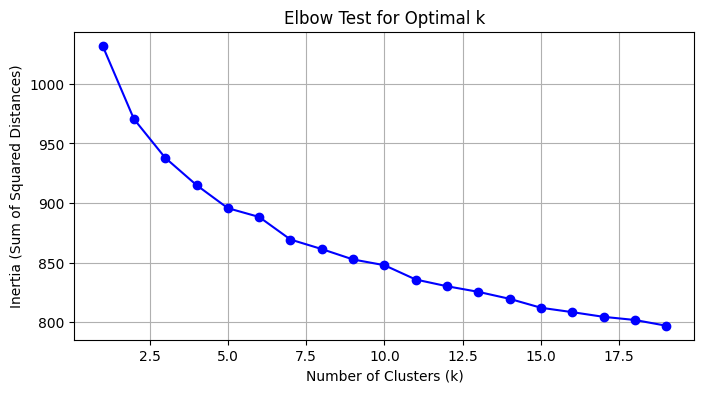

In [714]:
neighborhood_char_embeddings, neighborhood_char_sentences = get_embeddings('has_nhood_character')
elbow_test(neighborhood_char_embeddings)

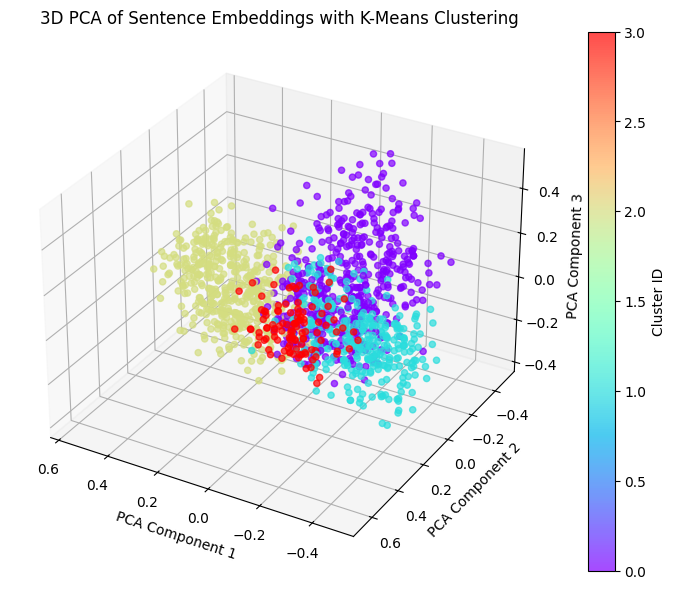

In [770]:
neighborhood_char_num_clusters = 4

test_neighborhood_char_sentences_embedded = get_labeled_sentences("labels/nhood_character_labeled.csv")
neighborhood_char_clusters, neighborhood_char_pred = k_means_classifier(neighborhood_char_embeddings, num_clusters=neighborhood_char_num_clusters, seed=42, n_init=30, test_embeddings=test_neighborhood_char_sentences_embedded)

neighborhood_char_clusters_df = pd.DataFrame({'Sentence': neighborhood_char_sentences, 'Cluster': neighborhood_char_clusters})
pca_plot(neighborhood_char_embeddings, neighborhood_char_clusters)

In [766]:
neighborhood_char_example_sentences = 4
example_sentences(neighborhood_char_clusters_df, neighborhood_char_num_clusters, neighborhood_char_example_sentences)


Cluster 0:
- Capri capital partners, plants, redevelopment plans as apartments condos and hotel to the Khrinchal Mall, which severely changes it from a retail development to a housing development with some retail shops.
- One of those categories is population and housing and it talks about displacement of people and replacing and replacement housing.
- Theres crime, theres, its run down and we dont see anyone waiting in line to help rehabilitate that property until preservation partners came into the the picture.
- And so discussing redevelopment plans that dont exist and support from political figures who are not present doesnt help us.

Cluster 1:
- So I just wanna clarify with you that when you, and your testimony say that this project is, is immediately adjacent to a residential neighborhood.
- Is that correct how the community feels?
- We talked about that and we thought that character, neighborhood characters, one thing that might not be able to be totally quantified.
- Preserve

In [767]:
neighborhood_char_cluster_labels = {
    0: "redevelopment and displacement concerns",
    1: "preserving existing neighborhood amidst new developments",
    2: "historical preservation",
    3: ""
}


neighborhood_char_cluster_breakdown_df = display_cluster_breakdown(neighborhood_char_clusters_df, neighborhood_char_cluster_labels)
neighborhood_char_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,35.95%,redevelopment and displacement concerns
1,23.22%,preserving existing neighborhood amidst new de...
2,32.90%,historical preservation
3,7.93%,


accuracy

In [718]:
def get_true_labels(label_file):
  labeled_sentences_df = pd.read_csv(label_file)
  # labeled_sentences_ls = labeled_sentences_df["sentence"].tolist()
  true_labels_ls = labeled_sentences_df["label"].tolist()

  # # labeled_sentences_embedded = model.encode(labeled_sentences_ls)
  # pred_labels = kmeans_model.predict(labeled_sentences_embedded)
  # pred_labels_ls = pred_labels.tolist()

  # pred_labels_ls = [9 if label not in other_labels else label for label in pred_labels_ls]
  
  return true_labels_ls


In [719]:
def get_accuracy_scores(true_labels, pred_labels):
  accuracy = accuracy_score(true_labels, pred_labels)

  report = classification_report(true_labels, pred_labels, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  report_df = report_df.round(2)  # Round to 2 decimal places for better readability

  return accuracy, report_df

In [720]:
parking_not_other = {0,1,5}
parking_true = get_true_labels("labels/parking_labeled.csv")
parking_pred_edited = [9 if label not in parking_not_other else label for label in parking_pred]


parking_accuracy, parking_report_df = get_accuracy_scores(parking_true, parking_pred_edited)

print(f"Parking Accuracy: {parking_accuracy:.2f}")
parking_report_df

Parking Accuracy: 0.72


,precision,recall,f1-score,support
0,0.44,0.80,0.57,5.00
1,0.78,0.88,0.82,8.00
5,0.71,0.50,0.59,10.00
9,0.80,0.74,0.77,27.00
accuracy,0.72,0.72,0.72,0.72
macro avg,0.68,0.73,0.69,50.00
weighted avg,0.74,0.72,0.72,50.00


In [726]:
nuisance_not_other = {0,1,2,3,4}
nuisance_true = get_true_labels("labels/nuisance_labeled.csv")
nuisance_pred_edited = [9 if label not in nuisance_not_other else label for label in nuisance_pred]


nuisance_accuracy, nuisance_report_df = get_accuracy_scores(nuisance_true, nuisance_pred_edited)

print(f"Nuisance Accuracy: {nuisance_accuracy:.2f}")
nuisance_report_df

Nuisance Accuracy: 0.82


,precision,recall,f1-score,support
0,1.00,1.00,1.00,7.00
1,1.00,0.79,0.88,19.00
2,1.00,0.91,0.95,11.00
3,0.80,0.80,0.80,10.00
4,0.12,0.33,0.18,3.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.78,0.77,0.76,50.00
weighted avg,0.91,0.82,0.86,50.00


In [744]:
affordable_housing_not_other = {0, 2, 4}
affordable_housing_true = get_true_labels("labels/affordablehousing_labeled.csv")
affordable_housing_pred_edited = [9 if label not in affordable_housing_not_other else label for label in affordable_housing_pred]


affordable_housing_accuracy, affordable_housing_report_df = get_accuracy_scores(affordable_housing_true, affordable_housing_pred_edited)

print(f"Affordable Housing Accuracy: {affordable_housing_accuracy:.2f}")
affordable_housing_report_df

Affordable Housing Accuracy: 0.93


,precision,recall,f1-score,support
0,0.82,1.00,0.90,9.00
2,1.00,1.00,1.00,6.00
4,1.00,1.00,1.00,3.00
9,1.00,0.83,0.91,12.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.95,0.96,0.95,30.00
weighted avg,0.95,0.93,0.93,30.00


In [774]:
affordable_housing_not_other = {0, 1, 2}
affordable_housing_true = get_true_labels("labels/nhood_character_labeled.csv")
affordable_housing_pred_edited = [9 if label not in affordable_housing_not_other else label for label in affordable_housing_pred]


affordable_housing_accuracy, affordable_housing_report_df = get_accuracy_scores(affordable_housing_true, affordable_housing_pred_edited)

print(f"Affordable Housing Accuracy: {affordable_housing_accuracy:.2f}")
affordable_housing_report_df

Affordable Housing Accuracy: 0.70


,precision,recall,f1-score,support
0,0.91,1.00,0.95,10.0
1,1.00,0.50,0.67,8.0
2,0.50,0.38,0.43,8.0
9,0.44,1.00,0.62,4.0
accuracy,0.70,0.70,0.70,0.7
macro avg,0.71,0.72,0.67,30.0
weighted avg,0.76,0.70,0.69,30.0
